<a href="https://colab.research.google.com/github/moeinset/data/blob/main/MS_iron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import needed frameworks and libraries
import torch
import torchvision


print(torch.__version__)
print(torchvision.__version__)


2.0.1+cu118
0.15.2+cu118


In [2]:





#define device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the needed directory, download it from GitHub if it doesn't work
try:
    from mymodules import data_setup, engine, get_data, utils
except:
    # Get the  scripts
    print("[INFO] Couldn't find Modular scripts... downloading them from GitHub.")
    !git clone https://github.com/moeinset/modules
    !mv  modules/mymodules .
    !rm -rf modules
    from mymodules import data_setup, engine, get_data, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find Modular scripts... downloading them from GitHub.
Cloning into 'modules'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 7.37 KiB | 2.46 MiB/s, done.


In [4]:
#import needed modules
from mymodules import data_setup
from mymodules import engine
from mymodules import get_data
from mymodules import utils

In [12]:


image_path = get_data.download_data(source="https://github.com/moeinset/data/blob/main/MS-iron.zip",
                           destination="iron-noneiron")
image_path



[INFO] data/iron-noneiron directory exists, skipping download.


PosixPath('data/iron-noneiron')

In [13]:


# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"



Random image path: data/iron-noneiron/train/iron/2.png
Image class: iron
Image height: 638
Image width: 1222


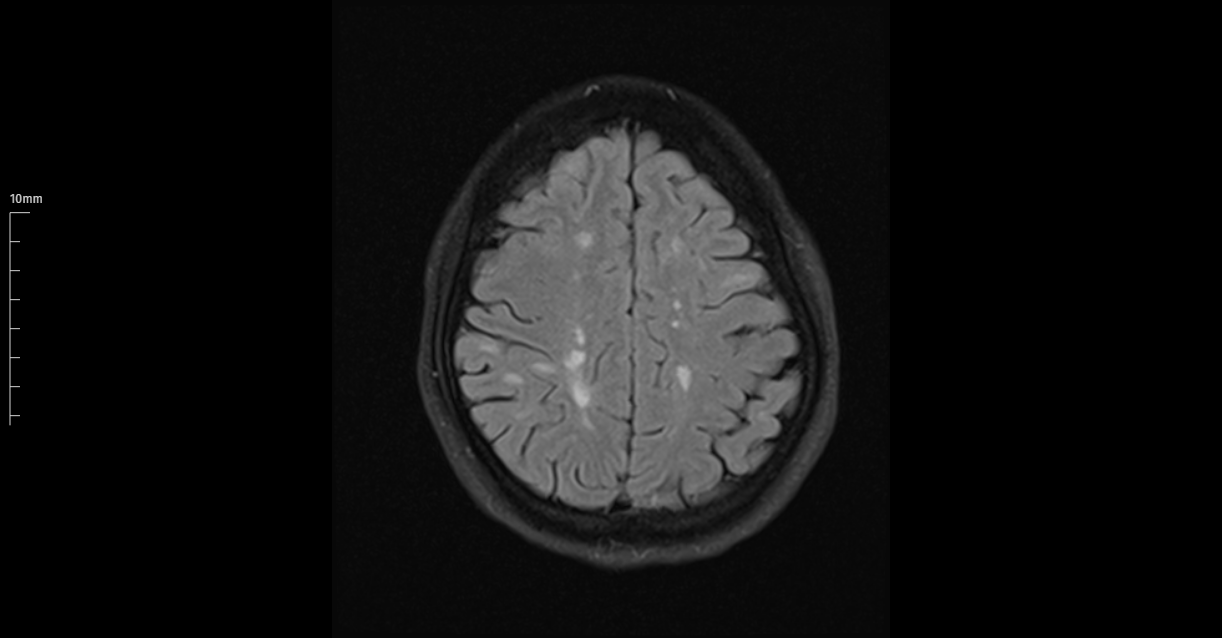

In [16]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [22]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [33]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/iron-noneiron'.
There are 2 directories and 0 images in 'data/iron-noneiron/train'.
There are 0 directories and 16 images in 'data/iron-noneiron/train/iron'.
There are 0 directories and 16 images in 'data/iron-noneiron/train/noneiron'.
There are 2 directories and 0 images in 'data/iron-noneiron/test'.
There are 0 directories and 6 images in 'data/iron-noneiron/test/iron'.
There are 0 directories and 6 images in 'data/iron-noneiron/test/noneiron'.


In [34]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

In [35]:


# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               test_transform=auto_transforms,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x788e149e58d0>,
 ['iron', 'noneiron'])

In [36]:
# N Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 60.7MB/s]


In [37]:


# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [38]:


# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False



In [39]:


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)



In [40]:




# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(8, 3, 224, 224), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)





Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [8, 3, 224, 224]     [8, 2]               --                   Partial
├─Sequential (features)                                      [8, 3, 224, 224]     [8, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [8, 3, 224, 224]     [8, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [8, 3, 224, 224]     [8, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [8, 32, 112, 112]    [8, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [8, 32, 112, 112]    [8, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [8, 32, 112, 112]    [8, 1

In [41]:


# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [42]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=40,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7281 | train_acc: 0.4062 | test_loss: 0.7380 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.6535 | train_acc: 0.5938 | test_loss: 0.7357 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.5817 | train_acc: 0.7812 | test_loss: 0.7266 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.5048 | train_acc: 0.8125 | test_loss: 0.7105 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.4829 | train_acc: 0.9062 | test_loss: 0.6885 | test_acc: 0.5833
Epoch: 6 | train_loss: 0.4363 | train_acc: 0.9375 | test_loss: 0.6660 | test_acc: 0.6667
Epoch: 7 | train_loss: 0.4140 | train_acc: 0.9062 | test_loss: 0.6415 | test_acc: 0.6667
Epoch: 8 | train_loss: 0.3680 | train_acc: 0.9062 | test_loss: 0.6222 | test_acc: 0.6667
Epoch: 9 | train_loss: 0.3635 | train_acc: 0.9688 | test_loss: 0.6117 | test_acc: 0.6667
Epoch: 10 | train_loss: 0.3089 | train_acc: 1.0000 | test_loss: 0.6136 | test_acc: 0.6667
Epoch: 11 | train_loss: 0.2907 | train_acc: 1.0000 | test_loss: 0.6267 | test_acc: 0.6667
Epoch: 12 | train_l

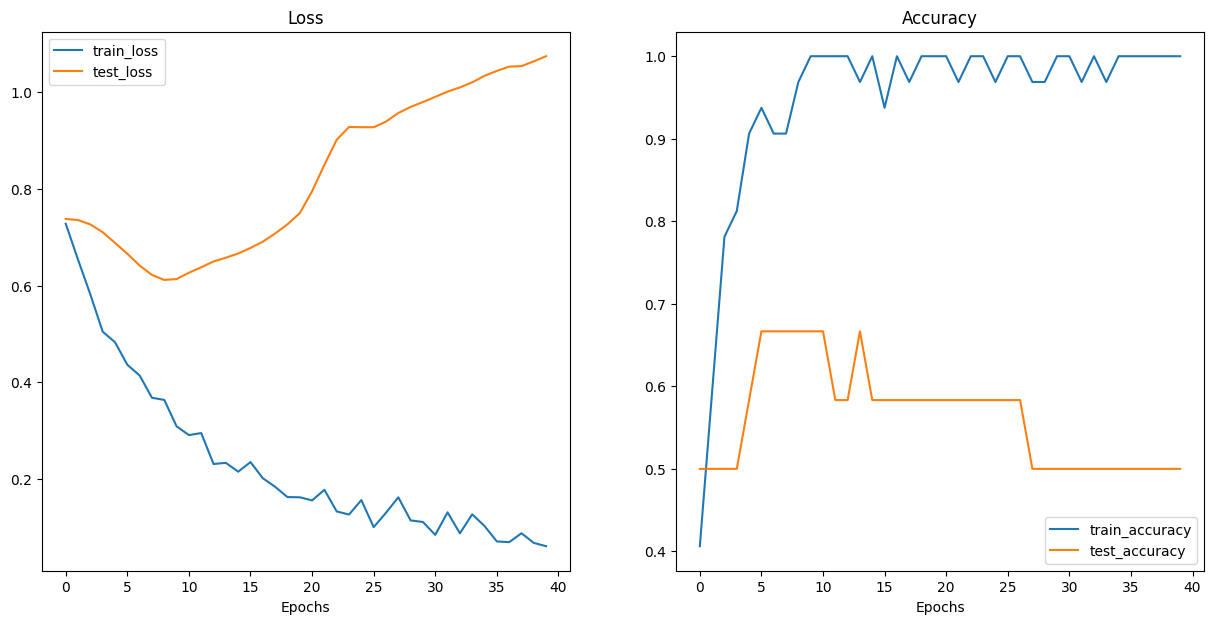

In [43]:


utils.plot_loss_curves(results)

